In [26]:
library(ggplot2)
library(ggpubr)
library(RColorBrewer)
library(ggrepel)
library(argparse)
library(Matrix)
library(data.table)
library(dplyr)
library(data.table)
library(wesanderson)

options(bitmapType = 'cairo', device = 'png')
Sys.setlocale("LC_NUMERIC", "C")

setwd('/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT/')
fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
simulation_pathway <- get(load('OUTPUT_GTEx/predict_CAD/simulation_pathway/simulation_tscores_varying_corr.RData'))
outFold <- sprintf('%sSimulation_CAD_pathway/', fold_notebook)

fold_CAD <- 'OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/'
pheno <- 'CAD_HARD'

# load results
tscore <- fread(sprintf('%stscore_pval_%s_covCorr.txt', fold_CAD, pheno), 
                h=T, stringsAsFactors = F, sep = '\t', data.table = F)

pathR <- fread(sprintf('%spath_Reactome_pval_%s_covCorr_filt.txt', fold_CAD, pheno), 
               h=T, stringsAsFactors = F, sep = '\t', data.table = F)

pathGO <- fread(sprintf('%spath_GO_pval_%s_covCorr_filt.txt', fold_CAD, pheno), 
                h=T, stringsAsFactors = F, sep = '\t', data.table = F)

pathWiki <- fread(sprintf('%spath_WikiPath2019Human_pval_%s_covCorr_filt.txt', fold_CAD, pheno), 
               h=T, stringsAsFactors = F, sep = '\t', data.table = F)


[1] "C"

In [76]:
#### function to plot results ####

plot_diff <- function(title_plot, res, version_id=1, file_name){
    
      
      if(version_id == 1){
          xlab_name <- 'corr. min-max'
          res$type <- factor(res$type)
      }
    
      if(version_id == 2){
          xlab_name <- 'n. correlated genes'
          res$type <- factor(res$type, levels = sort(unique(res$type)))
      }

      pl <- ggplot(data=res, aes(x=type, y=mean_diff, color = gene_set_z)) +
          geom_boxplot(outlier.shape = NA)+
          geom_point(size = 0.8, alpha = 0.9, position = position_jitterdodge(jitter.width = 0.2))+
          geom_hline(yintercept = 0, color = 'red', linetype = 2)+
          scale_color_gradientn(colours = rainbow(10))+
          xlab(xlab_name)+ylab(expression(mean(Z[pathway] - Z[gene])))+
          theme_bw()+theme(plot.title = element_text(size = 13, hjust = 0.5),
                       legend.title = element_text(size=11),
                       legend.text = element_text(size=11), 
                       axis.title = element_text(size=13), 
                       axis.text.x = element_text(angle = 45, hjust = 1),
                       axis.text = element_text(size=12))+
          labs(color = expression(Z[pathway]))+
          ggtitle(title_plot)
    
    ggsave(filename = paste0(file_name, '.pdf'), plot = pl, width = 5, height = 5)
    ggsave(filename = paste0(file_name, '.png'), plot = pl, width = 5, height = 5, dpi = 300)

    return(pl)
    
}

plot_corrgenes_pvaluepath <- function(df_path, plot_title, file_name){
    
   
    df_path$log10p <- -log10(df_path$CAD_HARD_pval)
    df_path$abs_mean_gene_corr <- abs(df_path$mean_gene_corr)
    corr_val <- round(cor(df_path$log10p, abs(df_path$mean_gene_corr), method = 'spearman'), 3)
 
    if(nrow(df_path) < 100){
        geom_point_size = 2
        breaks_n <- round(seq(2, max(df_path$ngenes_tscore), length.out = 5))
         trans_pl <- 'identity'
    }else{
        geom_point_size = 0.8
        breaks_n <- c(seq(2, 10, by=2),seq(50, 200, by=50),400)
         trans_pl <- 'log'
    }
    
    pl <- ggplot(data=df_path, aes(x=log10p, y=abs_mean_gene_corr, color = ngenes_tscore)) +
       geom_point(size = geom_point_size, alpha = 0.8)+
       scale_color_gradientn(colours = rainbow(length(breaks_n)), 
                             breaks = breaks_n,  trans = trans_pl,)+
          theme_bw()+theme(plot.title = element_text(size = 13, hjust = 0.5), legend.key.height = unit(2, 'cm'),
                       legend.title = element_text(size=11),
                       legend.text = element_text(size=10), 
                       axis.title = element_text(size=13), 
                       axis.text = element_text(size=12))+
          xlab(expression(-log[10](P[Pathway])))+
          ylab("|Mean gene corr|")+
          geom_text(color = 'black', 
                    x=Inf, y=Inf, 
                   label=paste0('Spearman\ncorr. ', as.character(corr_val)), 
                   hjust=1.5, vjust = 2)+
          labs(color = "N. genes")+
          ggtitle(plot_title)

    ggsave(filename = paste0(file_name, '.pdf'), plot = pl, width = 5, height = 5)
    ggsave(filename = paste0(file_name, '.png'), plot = pl, width = 5, height = 5, dpi = 300)

    
    return(pl)
    
}

compute_average_diff <-  function(df_path, df_tscore){
    
    df_path$mean_path_minus_gene_z <- NA
    df_path$sd_path_minus_gene_z <- NA
    
    for(i in 1:nrow(df_path)){
    
        tissue_i <- df_path$tissue[i]
        genes <- strsplit(df_path$genes_path[i], split = ',')[[1]]
        genes_tscore <- df_tscore %>% filter(tissue == tissue_i, external_gene_name %in% genes)
        df_path$average_path_minus_gene_z[i] <- mean(df_path$CAD_HARD_z_t[i] - genes_tscore$CAD_HARD_z_t)
        df_path$sd_path_minus_gene_z[i] <- sd(df_path$CAD_HARD_z_t[i] - genes_tscore$CAD_HARD_z_t)
    
    }
    return(df_path)
}

plot_corrgenes_diffzstat <- function(df_path, plot_title, file_name){
    
    corr_val <- round(cor(df_path$average_path_minus_gene_z, (df_path$mean_gene_corr), method = 'spearman'), 3)
 
    if(nrow(df_path) < 100){
        geom_point_size = 2
        breaks_n <- round(seq(2, max(df_path$ngenes_tscore), length.out = 5))
        trans_pl <- 'identity'
    }else{
        geom_point_size = 0.8
        breaks_n <- c(seq(2, 10, by=2),seq(50, 200, by=50),400)
        trans_pl <- 'log'
    }
    
    pl <- ggplot(data=df_path, aes(x=average_path_minus_gene_z, y=mean_gene_corr, color = ngenes_tscore)) +
       geom_point(size = geom_point_size, alpha = 0.8)+
       scale_color_gradientn(colours = rainbow(length(breaks_n)), 
                             breaks = breaks_n,  trans = trans_pl,)+
          theme_bw()+theme(plot.title = element_text(size = 13, hjust = 0.5), legend.key.height = unit(2, 'cm'),
                       legend.title = element_text(size=11),
                       legend.text = element_text(size=10), 
                       axis.title = element_text(size=13), 
                       axis.text = element_text(size=12))+
          xlab(expression(mean(Z[pathway] - Z[gene])))+
          ylab("Mean gene corr")+
          geom_text(color = 'black', 
                    x=Inf, y=Inf, 
                   label=paste0('Spearman\ncorr. ', as.character(corr_val)), 
                   hjust=1.5, vjust = 2)+
          labs(color = "N. genes")+
          ggtitle(plot_title)

    ggsave(filename = paste0(file_name, '.pdf'), plot = pl, width = 5, height = 5)
    ggsave(filename = paste0(file_name, '.png'), plot = pl, width = 5, height = 5, dpi = 300)

    
    return(pl)
    
}

    


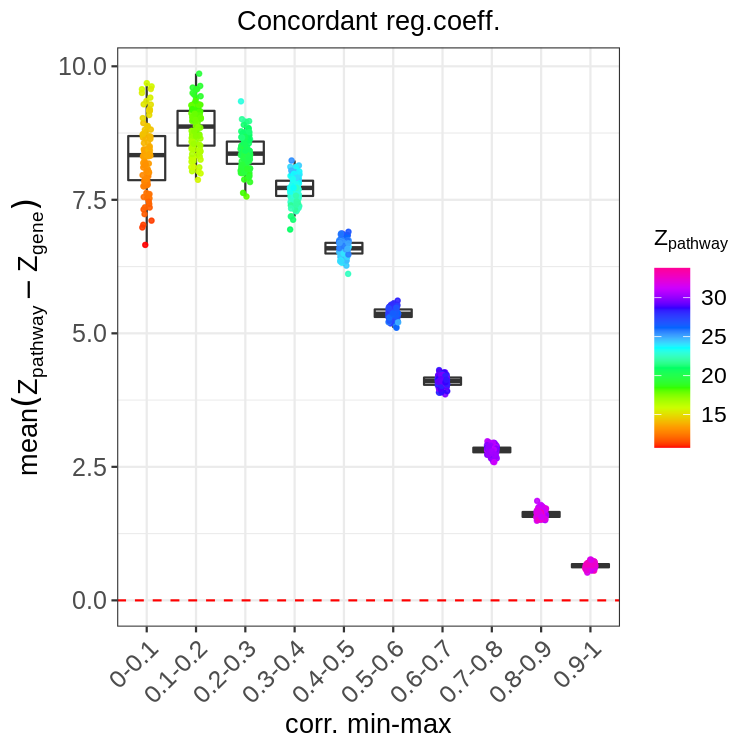

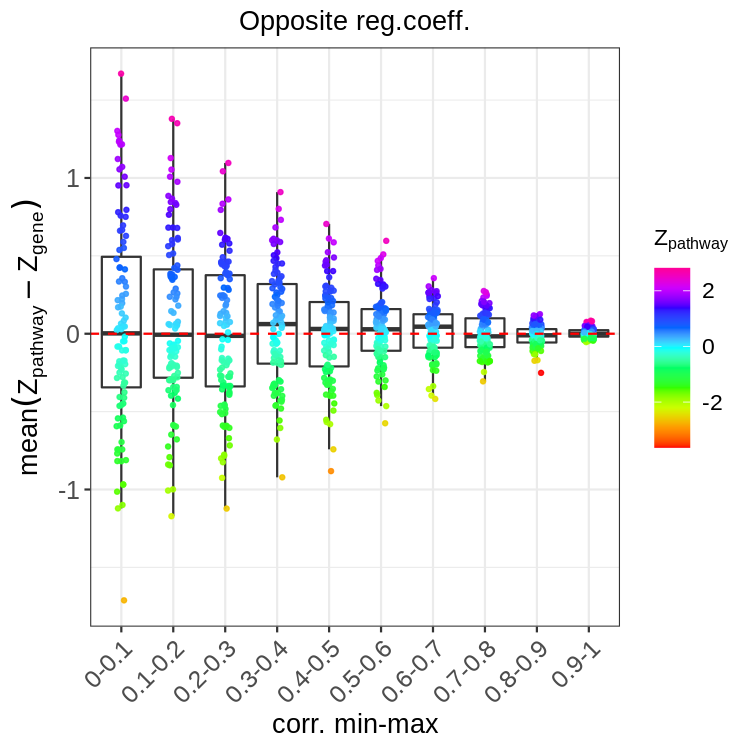

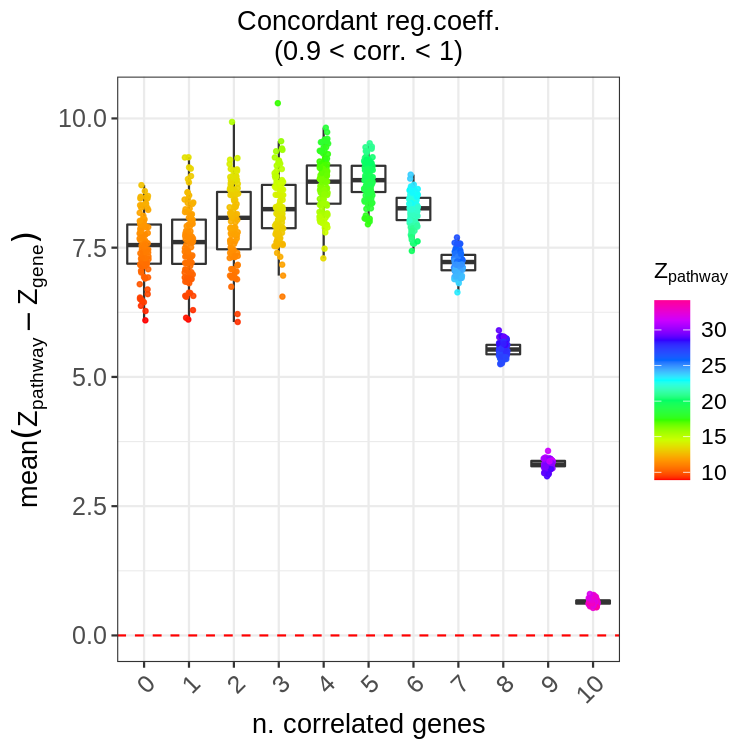

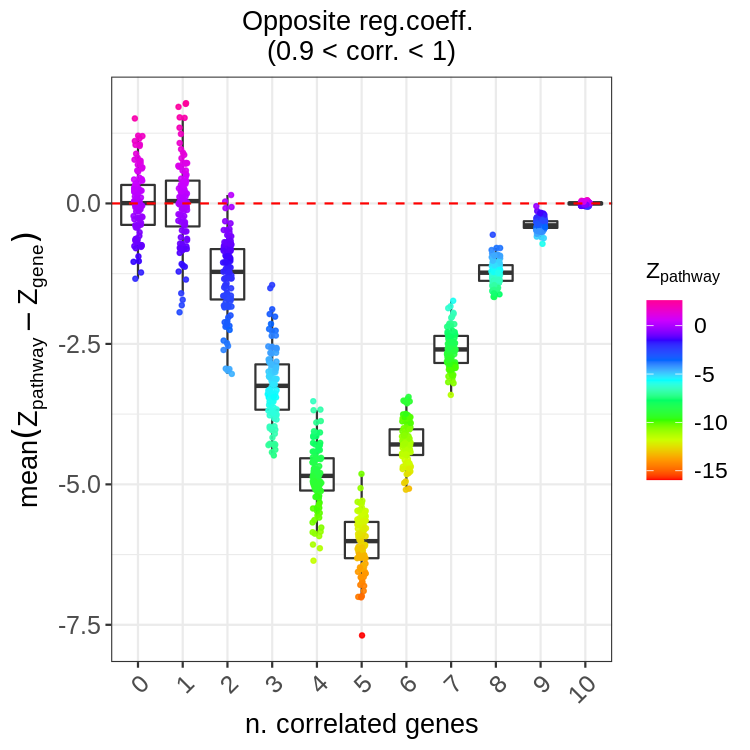

In [24]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 150)

plot_diff(title_plot = 'Concordant reg.coeff.', version_id = 1, 
          file_name = sprintf('%sconcordant_beta_v1', outFold),
          res = simulation_pathway$concordant_beta_v1)

plot_diff(title_plot = 'Opposite reg.coeff.', version_id = 1, 
          file_name = sprintf('%sopposite_beta_v1', outFold),
          res = simulation_pathway$opposite_beta_v1)

plot_diff(title_plot = 'Concordant reg.coeff.\n(0.9 < corr. < 1)', version_id = 2, 
          file_name = sprintf('%sconcordant_beta_v2', outFold),
          res = simulation_pathway$concordant_beta_v2)

plot_diff(title_plot = 'Opposite reg.coeff. \n(0.9 < corr. < 1)', version_id = 2, 
          file_name = sprintf('%sopposite_beta_v2', outFold),
          res = simulation_pathway$opposite_beta_v2)

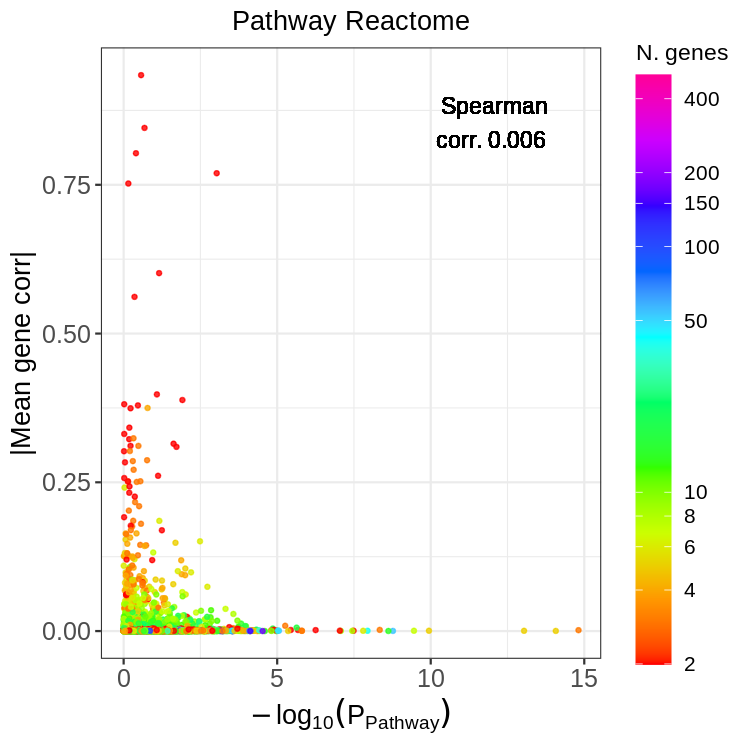

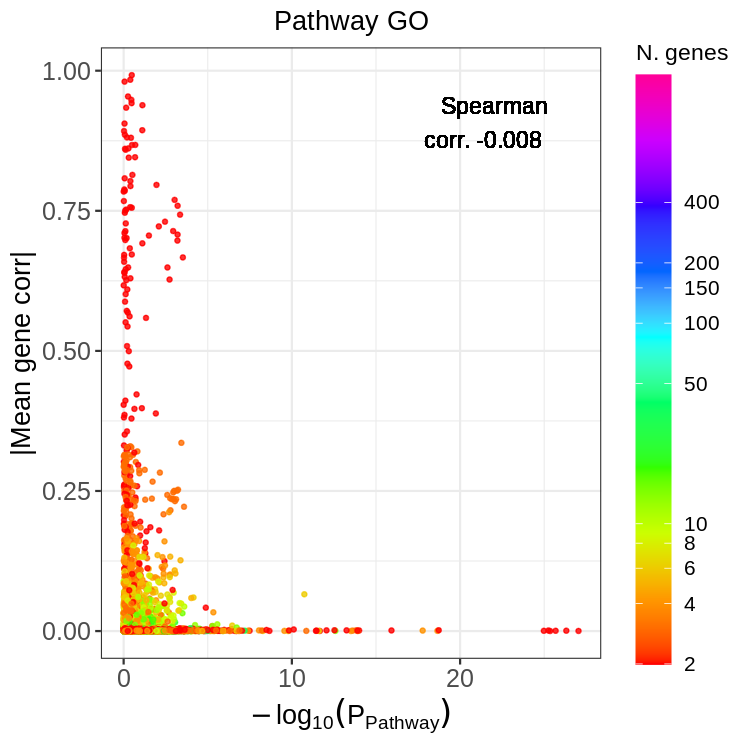

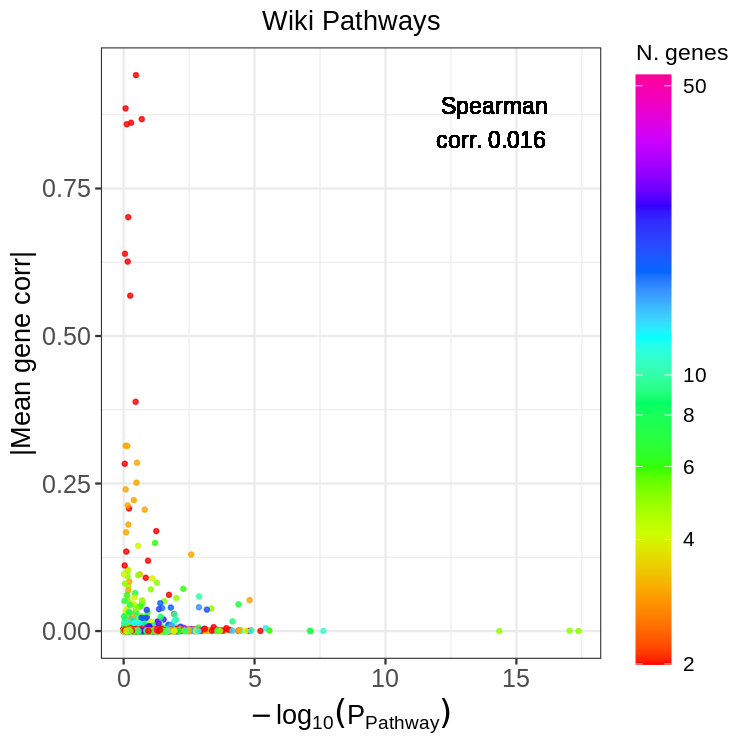

In [70]:
plot_corrgenes_pvaluepath(df_path = pathR, plot_title = 'Pathway Reactome', 
                              file_name = sprintf('%spathR_pvalue_vs_genecorr', outFold))

plot_corrgenes_pvaluepath(df_path = pathGO, plot_title = 'Pathway GO', 
                              file_name = sprintf('%spathGO_pvalue_vs_genecorr', outFold))

plot_corrgenes_pvaluepath(df_path = pathWiki, plot_title = 'Wiki Pathways', 
                              file_name = sprintf('%spathWiki_pvalue_vs_genecorr', outFold))

In [45]:
# same plot but with average gene-pathway difference:
pathR_ann <- compute_average_diff(df_path = pathR, df_tscore = tscore)
pathGO_ann <- compute_average_diff(df_path = pathGO, df_tscore = tscore)
pathWiki_ann <- compute_average_diff(df_path = pathWiki, df_tscore = tscore)


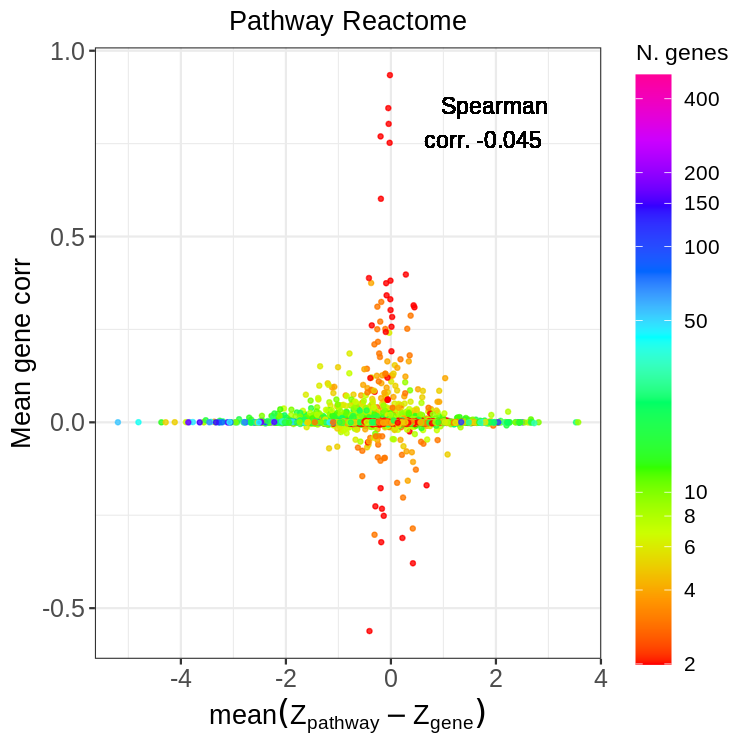

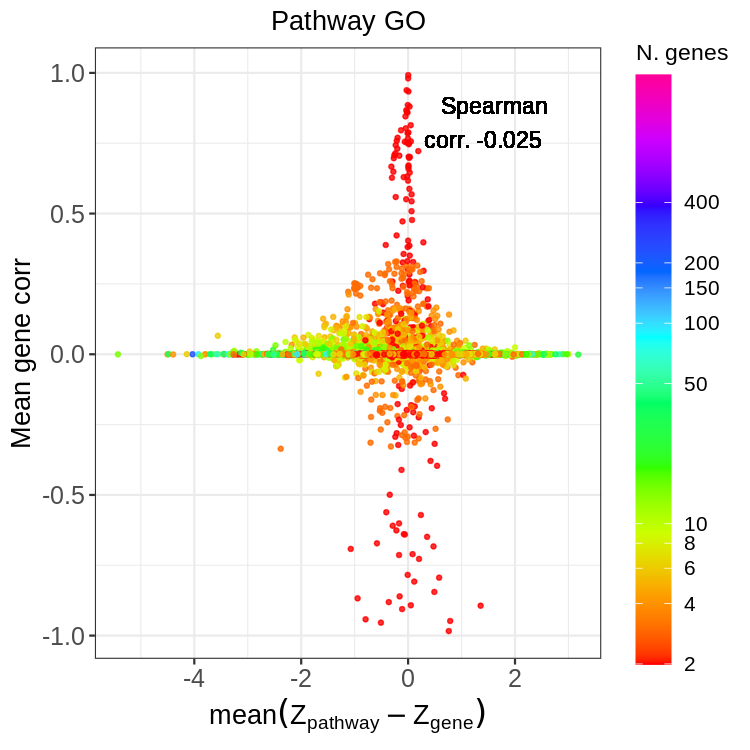

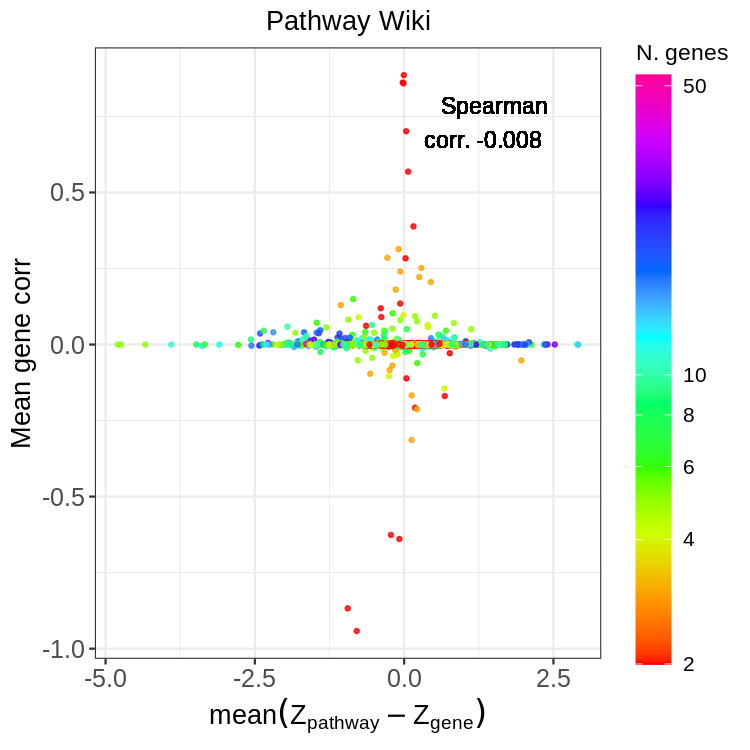

In [71]:
plot_corrgenes_diffzstat(df_path = pathR_ann, plot_title = 'Pathway Reactome', 
                              file_name = sprintf('%spathR_diffz_vs_genecorr', outFold))

plot_corrgenes_diffzstat(df_path = pathGO_ann, plot_title = 'Pathway GO', 
                              file_name = sprintf('%spathGO_diffz_vs_genecorr', outFold))

plot_corrgenes_diffzstat(df_path = pathWiki_ann, plot_title = 'Pathway Wiki', 
                              file_name = sprintf('%spathWiki_diffz_vs_genecorr', outFold))


In [72]:
# loci analysis
fold <- 'OUTPUT_GTEx/predict_CAD/Whole_Blood/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/'
gene_set_locus <- get(load(sprintf('%sgeneSets_sameLocus_sameSign.RData', fold)))
res <- get(load(sprintf('%spval_CAD_pheno_covCorr_customPath_geneSets_sameLocus.RData', fold)))
path_locus <- fread(sprintf('%ssummary_geneSets_sameLocus.txt', fold), h=T, 
                    stringsAsFactors = F, sep = '\t', data.table = F)
df_tscore <- res$tscore[[1]]
df_tscore$tissue <- 'Whole_Blood'
path_locus$tissue <- 'Whole_Blood'
df_path_ann <- compute_average_diff(df_path = path_locus, df_tscore = df_tscore)

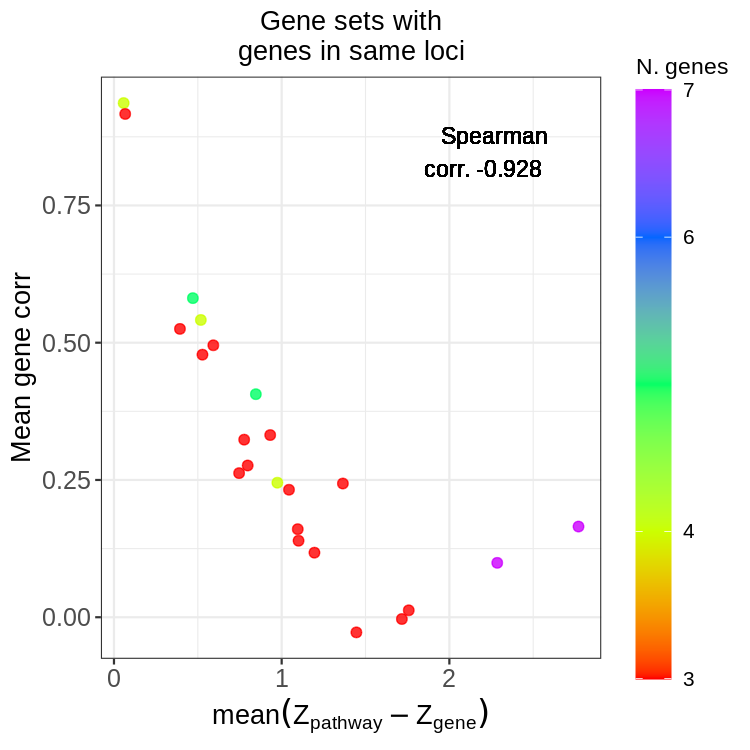

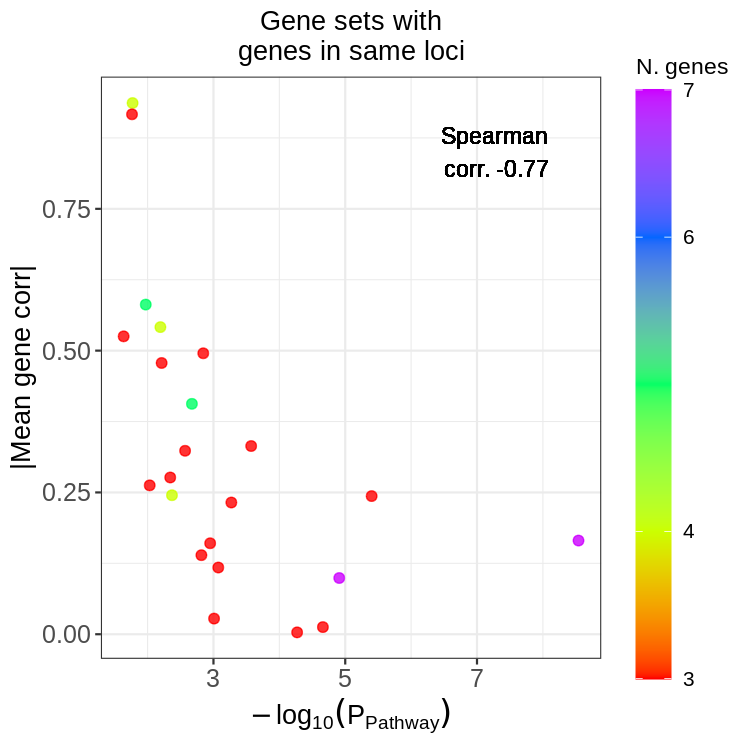

In [77]:
plot_corrgenes_diffzstat(df_path = df_path_ann, plot_title = 'Gene sets with\ngenes in same loci', 
                              file_name = sprintf('%sgeneSets_sameLocus_diffz_vs_genecorr', outFold))

plot_corrgenes_pvaluepath(df_path = df_path_ann, plot_title = 'Gene sets with\ngenes in same loci', 
                              file_name = sprintf('%sgeneSets_sameLocus_pvalue_vs_genecorr', outFold))